In [17]:
from DOPU_given_timerange import get_combined_cleaned_one_month_df

get_combined_cleaned_one_month_df()

In [32]:
# === Construct (s,a,r,s') using the nearest 5 zone based on euclidean_distance ===

from zone_coords import get_coord_as_csv
# Required packages
import pandas as pd
import numpy as np
import json

# === Step 1: Load Parquet taxi trip data ===
df = pd.read_parquet('./all_cleaned_data/combined_cleaned_data_2024-01.parquet')

# === Step 2: Load zone coordinates ===
# CSV should contain: LocationID, Latitude, Longitude
get_coord_as_csv()
zone_coords_df = pd.read_csv('zone_coords.csv')
zone_coords = {
    int(row['LocationID']): (row['Latitude'], row['Longitude'])
    for _, row in zone_coords_df.iterrows()
}

# === Step 3: Load zone neighbor dictionary from JSON ===
with open('zone_neighbors.json', 'r') as f:
    neighbor_dict = json.load(f)

# Convert string keys and values to integers
neighbor_dict = {int(k): [int(n) for n in v] for k, v in neighbor_dict.items()}

# === Step 4: Helper functions ===

# Convert a timestamp into a 30-minute time bin index (0 to 47)
def get_time_bin_half_hour(dt):
    return dt.hour * 2 + dt.minute // 30


# Convert a timestamp into a 15-minute time bin index (0 to 95)
def get_time_bin_fifteen_minutes(timestamp):
    return timestamp.hour * 4 + timestamp.minute // 15  # 15min per bin


# Compute Euclidean distance between two (lat, lon) coordinates
def euclidean_distance(coord1, coord2):
    return np.linalg.norm(np.array(coord1) - np.array(coord2))

# Compute reward: fare minus 0.5 * empty travel distance
def compute_reward(fare, empty_distance):
    return fare - 0.5 * empty_distance

# === Step 5: Construct (s, a, r, s′) tuples ===

samples = []

num_time_bins = 96

for _, row in df.iterrows():
    try:
        # Extract key fields
        s_zone = int(row['PULocationID'])
        pickup_time = pd.to_datetime(row['PickupDatetime'])
        fare = float(row['FareAmount'])

        # Skip invalid or missing data
        if s_zone not in zone_coords or s_zone not in neighbor_dict:
            continue

        # Define current state
        t_bin = get_time_bin_fifteen_minutes(pickup_time)
        s = (s_zone, t_bin)

        # Loop over each possible neighbor as an action
        for a_zone in neighbor_dict[s_zone]:
            if a_zone not in zone_coords:
                continue

            # Calculate distance between zones
            dist = euclidean_distance(zone_coords[s_zone], zone_coords[a_zone])

            # Calculate reward for moving to that zone
            reward = compute_reward(fare, dist)

            # Next state: new zone, 30/15 minutes later
            s_prime = (a_zone, (t_bin + 1) % num_time_bins)

            # Save sample
            samples.append({
                's_zone': s_zone,
                't_bin': t_bin,
                'a_zone': a_zone,
                'reward': reward,
                's_prime_zone': s_prime[0],
                's_prime_t_bin': s_prime[1]
            })

    except Exception as e:
        # Silently skip problematic rows
        continue

# Convert to DataFrame and save
samples_df = pd.DataFrame(samples)

KeyboardInterrupt: 

In [1]:
# === Packages ===
import pandas as pd
import numpy as np

# === Step 1: Load Parquet taxi trip data ===
df = pd.read_parquet('./cleaned_data/cleaned_yellow_tripdata_2024-01.parquet')

# === Step 2: Preprocess: Add time bins ===
def get_time_bin_fifteen_minutes(timestamp):
    return timestamp.hour * 4 + timestamp.minute // 15  # 15 min bin

# Convert Pickup and Dropoff Datetime to time bins
df['pickup_time_bin'] = pd.to_datetime(df['PickupDatetime']).apply(get_time_bin_fifteen_minutes)
df['dropoff_time_bin'] = pd.to_datetime(df['DropoffDatetime']).apply(get_time_bin_fifteen_minutes)

# === Step 3: Build (s, a, r, s') Samples ===
samples = []

# Group by (pickup_zone, pickup_time_bin)
grouped = df.groupby(['PULocationID', 'pickup_time_bin'])

num_time_bins = 96

for (s_zone, t_bin), group in grouped:
    for _, trip in group.iterrows():
        try:
            # Current state (s_zone, t_bin)
            s = (s_zone, t_bin)

            # Action: pick this trip → dropoff zone
            a_zone = int(trip['DOLocationID'])
            fare = float(trip['FareAmount'])

            # Next state (dropoff zone, dropoff time bin)
            s_prime_zone = a_zone
            s_prime_t_bin = int(trip['dropoff_time_bin']) % num_time_bins

            # Save this (s, a, r, s') sample
            samples.append({
                's_zone': s_zone,
                't_bin': t_bin,
                'a_zone': a_zone,
                'reward': fare,
                's_prime_zone': s_prime_zone,
                's_prime_t_bin': s_prime_t_bin
            })

        except Exception as e:
            continue  # Ignore invalid rows
            
    try:
        samples.append({
            's_zone': s_zone,
            't_bin': t_bin,
            'a_zone': s_zone,  # stay
            'reward': -1.0,    # small negative reward for wasting time
            's_prime_zone': s_zone,
            's_prime_t_bin': (t_bin + 1) % num_time_bins
        })
    except Exception as e:
        continue

# === Step 4: Save to CSV ===
samples_df = pd.DataFrame(samples)
samples_df.to_csv('./data_for_q_learning/q_learning_samples_realistic_2024-01.csv', index=False)

print(f"✅ Done! Generated {len(samples_df)} (s, a, r, s') samples and saved to './data_for_q_learning/q_learning_samples_realistic_2024-01.csv'")


✅ Done! Generated 2681285 (s, a, r, s') samples and saved to './data_for_q_learning/q_learning_samples_realistic_2024-01.csv'


In [2]:
df = pd.read_csv("./data_for_q_learning/q_learning_samples_realistic_2024-01.csv")
df.head(1000)

,s_zone,t_bin,a_zone,reward,s_prime_zone,s_prime_t_bin
0,1,21,265,35.9,265,22
1,1,21,1,-1.0,1,22
2,1,24,1,70.0,1,26
3,1,24,1,-1.0,1,25
4,1,59,265,35.9,265,60
...,...,...,...,...,...,...
995,4,9,224,5.8,224,9
996,4,9,68,12.8,68,10
997,4,9,79,5.8,79,10
998,4,9,13,22.6,13,10


In [6]:
# === Packages ===
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import os

# === Step 1: Load the new (s, a, r, s') samples ===
num_time_bins = 96  # 15min
samples_path = './data_for_q_learning/q_learning_samples_realistic_2024-01.csv'
df = pd.read_csv(samples_path)

# Encode all zone IDs into continuous integer IDs
all_zone_ids = pd.unique(df[['s_zone', 'a_zone', 's_prime_zone']].values.ravel())
zone_id_map = {z: i for i, z in enumerate(sorted(all_zone_ids))}
num_zones = len(zone_id_map)

# Map original zone IDs to 0,1,2,3,... for embedding
df['s_zone'] = df['s_zone'].map(zone_id_map)
df['a_zone'] = df['a_zone'].map(zone_id_map)
df['s_prime_zone'] = df['s_prime_zone'].map(zone_id_map)

# === Step 2: Define PyTorch Dataset ===
class QLearningDataset(Dataset):
    def __init__(self, df):
        self.s_zone = torch.tensor(df['s_zone'].values, dtype=torch.long)
        self.t_bin = torch.tensor(df['t_bin'].values, dtype=torch.long)
        self.a_zone = torch.tensor(df['a_zone'].values, dtype=torch.long)
        self.reward = torch.tensor(df['reward'].values, dtype=torch.float32)
        self.s_prime_zone = torch.tensor(df['s_prime_zone'].values, dtype=torch.long)
        self.s_prime_t_bin = torch.tensor(df['s_prime_t_bin'].values, dtype=torch.long)

    def __len__(self):
        return len(self.s_zone)

    def __getitem__(self, idx):
        return (self.s_zone[idx], self.t_bin[idx], self.a_zone[idx],
                self.reward[idx], self.s_prime_zone[idx], self.s_prime_t_bin[idx])

dataset = QLearningDataset(df)
# dataloader = DataLoader(dataset, batch_size=4096, shuffle=True, num_workers=4)
dataloader = DataLoader(dataset, batch_size=4096, shuffle=True, num_workers=0)


# === Step 3: Define Q-network ===
class QNetwork(nn.Module):
    def __init__(self, num_zones, num_time_bins, embed_dim=16):
        super().__init__()
        self.zone_embed = nn.Embedding(num_zones, embed_dim)
        self.time_embed = nn.Embedding(num_time_bins, embed_dim)
        self.net = nn.Sequential(
            nn.Linear(embed_dim * 3, 128),  # 适度扩大 hidden layer
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, s_zone, t_bin, a_zone):
        s_embed = self.zone_embed(s_zone)
        t_embed = self.time_embed(t_bin)
        a_embed = self.zone_embed(a_zone)
        x = torch.cat([s_embed, t_embed, a_embed], dim=1)
        return self.net(x).squeeze(1)

# Instantiate models
q_net = QNetwork(num_zones, num_time_bins)
target_q_net = QNetwork(num_zones, num_time_bins)
target_q_net.load_state_dict(q_net.state_dict())  # Copy initial weights

# === Step 4: Setup training components ===
optimizer = optim.Adam(q_net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
gamma = 0.99

# === Step 5: Training loop ===
epochs = 20
epoch_losses = []
tau = 0.005  # Soft update coefficient

os.makedirs("./Q_learning", exist_ok=True)

for epoch in range(epochs):
    q_net.train()
    total_loss = 0
    tqdm_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}")

    for s, t, a, r, s_p, t_p in tqdm_bar:
        with torch.no_grad():
            a_prime = torch.arange(num_zones).repeat(len(s_p), 1).to(torch.long)
            s_prime_rep = s_p.unsqueeze(1).repeat(1, num_zones).flatten()
            t_prime_rep = t_p.unsqueeze(1).repeat(1, num_zones).flatten()
            a_prime_flat = a_prime.flatten()

            q_values = target_q_net(s_prime_rep, t_prime_rep, a_prime_flat)
            q_values = q_values.view(len(s_p), num_zones)
            max_q = q_values.max(dim=1)[0]

        target = r + gamma * max_q
        pred_q = q_net(s, t, a)
        loss = loss_fn(pred_q, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        tqdm_bar.set_postfix(batch_loss=loss.item())

        # === Soft update target network ===
        with torch.no_grad():
            for target_param, param in zip(target_q_net.parameters(), q_net.parameters()):
                target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    epoch_losses.append(total_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# === Step 6: Save model and loss ===
torch.save(q_net.state_dict(), f"./Q_learning/q_network_realistic_{epochs}_epochs.pt")
pd.DataFrame({'epoch': list(range(1, len(epoch_losses)+1)), 'loss': epoch_losses})\
  .to_csv(f"./Q_learning/q_training_loss_realistic_{epochs}_epochs.csv", index=False)

print(f"✅ Training finished. Model and loss history saved.")


Epoch 1: 100%|██████████| 655/655 [07:13<00:00,  1.51it/s, batch_loss=83.7]


Epoch 1, Loss: 95589.0429


Epoch 2: 100%|██████████| 655/655 [07:12<00:00,  1.51it/s, batch_loss=72.5]


Epoch 2, Loss: 49813.2337


Epoch 3: 100%|██████████| 655/655 [07:09<00:00,  1.53it/s, batch_loss=55.4]


Epoch 3, Loss: 41979.9844


Epoch 4: 100%|██████████| 655/655 [09:26<00:00,  1.16it/s, batch_loss=52.6]


Epoch 4, Loss: 35710.7257


Epoch 5: 100%|██████████| 655/655 [12:33<00:00,  1.15s/it, batch_loss=46.9]


Epoch 5, Loss: 31450.2858


Epoch 6: 100%|██████████| 655/655 [12:41<00:00,  1.16s/it, batch_loss=46]  


Epoch 6, Loss: 28771.6464


Epoch 7: 100%|██████████| 655/655 [08:16<00:00,  1.32it/s, batch_loss=37.6]


Epoch 7, Loss: 26607.2546


Epoch 8: 100%|██████████| 655/655 [06:41<00:00,  1.63it/s, batch_loss=39.3]


Epoch 8, Loss: 24961.0051


Epoch 9: 100%|██████████| 655/655 [06:46<00:00,  1.61it/s, batch_loss=39.6]


Epoch 9, Loss: 23849.0852


Epoch 10: 100%|██████████| 655/655 [07:56<00:00,  1.37it/s, batch_loss=30.7]


Epoch 10, Loss: 23036.5423


Epoch 11: 100%|██████████| 655/655 [08:45<00:00,  1.25it/s, batch_loss=33.8]


Epoch 11, Loss: 22165.0976


Epoch 12: 100%|██████████| 655/655 [08:45<00:00,  1.25it/s, batch_loss=36.7]


Epoch 12, Loss: 21663.6941


Epoch 13: 100%|██████████| 655/655 [07:00<00:00,  1.56it/s, batch_loss=34.2]


Epoch 13, Loss: 21142.6696


Epoch 14: 100%|██████████| 655/655 [06:52<00:00,  1.59it/s, batch_loss=28.4]


Epoch 14, Loss: 20871.1706


Epoch 15: 100%|██████████| 655/655 [06:51<00:00,  1.59it/s, batch_loss=30.8]


Epoch 15, Loss: 20610.0068


Epoch 16: 100%|██████████| 655/655 [06:48<00:00,  1.61it/s, batch_loss=28.3]


Epoch 16, Loss: 20362.0797


Epoch 17: 100%|██████████| 655/655 [07:12<00:00,  1.51it/s, batch_loss=36.6]


Epoch 17, Loss: 20232.3057


Epoch 18: 100%|██████████| 655/655 [07:12<00:00,  1.51it/s, batch_loss=25]  


Epoch 18, Loss: 20150.9315


Epoch 19: 100%|██████████| 655/655 [07:21<00:00,  1.48it/s, batch_loss=29]  


Epoch 19, Loss: 19943.0643


Epoch 20: 100%|██████████| 655/655 [07:05<00:00,  1.54it/s, batch_loss=25.7]

Epoch 20, Loss: 19863.5511
✅ Training finished. Model and loss history saved.


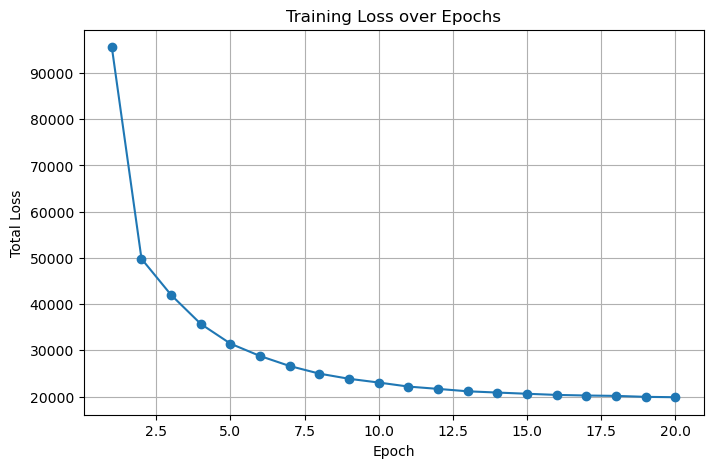

In [7]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()


In [2]:
import matplotlib.pyplot as plt

def plot_q_values_for_state(s_zone, t_bin, q_net, neighbor_dict, zone_id_map, inv_zone_map):
    """
    Visualize Q(s, a) values for all available actions from a given state.
    """
    s_zone_id = zone_id_map[s_zone]
    neighbors = neighbor_dict.get(s_zone_id, [])
    
    if not neighbors:
        print("❌ No neighbors for this zone.")
        return

    s_tensor = torch.tensor([s_zone_id] * len(neighbors), dtype=torch.long)
    t_tensor = torch.tensor([t_bin] * len(neighbors), dtype=torch.long)
    a_tensor = torch.tensor(neighbors, dtype=torch.long)

    with torch.no_grad():
        q_values = q_net(s_tensor, t_tensor, a_tensor).numpy()

    zone_labels = [inv_zone_map[a] for a in neighbors]

    plt.figure(figsize=(10, 4))
    plt.bar(zone_labels, q_values)
    plt.xlabel("Neighbor Zone ID (a)")
    plt.ylabel("Q(s, a)")
    plt.title(f"Q-values for s = (zone {s_zone}, time bin {t_bin})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [7]:
import torch.nn as nn
import pandas as pd
import torch
num_time_bins = 96 #15min time bin
input_path = f'./data_for_q_learning/q_learning_samples_{num_time_bins}.csv'
df = pd.read_csv(input_path)
# Encode all zone IDs into integer IDs
all_zone_ids = pd.unique(df[['s_zone', 'a_zone', 's_prime_zone']].values.ravel())
zone_id_map = {z: i for i, z in enumerate(sorted(all_zone_ids))}
num_zones = len(zone_id_map)
class QNetwork(nn.Module):
    def __init__(self, num_zones, num_time_bins, embed_dim=16):
        super().__init__()
        self.zone_embed = nn.Embedding(num_zones, embed_dim)
        self.time_embed = nn.Embedding(num_time_bins, embed_dim)
        self.net = nn.Sequential(
            nn.Linear(embed_dim * 3, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, s_zone, t_bin, a_zone):
        s_embed = self.zone_embed(s_zone)
        t_embed = self.time_embed(t_bin)
        a_embed = self.zone_embed(a_zone)
        x = torch.cat([s_embed, t_embed, a_embed], dim=1)
        return self.net(x).squeeze(1)
q_net = QNetwork(num_zones, num_time_bins)
q_net.load_state_dict(torch.load("Q_learning/q_network.pt"))
q_net.eval()


C:\Users\xiqiz\AppData\Local\Temp\ipykernel_14360\3921175257.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_net.load_state_dict(torch.load("Q_learning/q_network.pt")

QNetwork(
  (zone_embed): Embedding(255, 16)
  (time_embed): Embedding(96, 16)
  (net): Sequential(
    (0): Linear(in_features=48, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

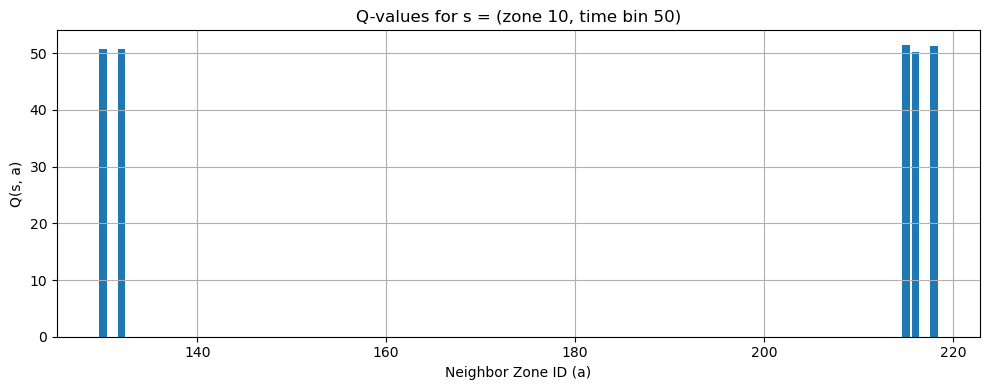

In [13]:
import json
df = pd.read_csv("./data_for_q_learning/q_learning_samples_96.csv")
zone_ids = pd.unique(df[['s_zone', 'a_zone', 's_prime_zone']].values.ravel())
zone_id_map = {z: i for i, z in enumerate(sorted(zone_ids))}
inv_zone_map = {v: k for k, v in zone_id_map.items()}
with open("zone_neighbors.json", "r") as f:
    neighbor_dict_raw = json.load(f)
neighbor_dict = {zone_id_map[int(k)]: [zone_id_map[int(n)] for n in v if int(n) in zone_id_map] 
                 for k, v in neighbor_dict_raw.items() if int(k) in zone_id_map}
plot_q_values_for_state(
    s_zone=10, 
    t_bin=50,    
    q_net=q_net,
    neighbor_dict=neighbor_dict,
    zone_id_map=zone_id_map,
    inv_zone_map=inv_zone_map
)

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_avg_reward_distribution(csv_path, top_n=30):
    """
    Plot average reward for top N (s_zone, a_zone) pairs.

    Args:
        csv_path: path to your q_learning_samples_96.csv
        top_n: number of (s,a) pairs to plot
    """
    df = pd.read_csv(csv_path)
    grouped = df.groupby(['s_zone', 'a_zone'])['reward'].mean().reset_index()
    grouped_sorted = grouped.sort_values(by='reward', ascending=False).head(top_n)

    labels = [f"{int(s)}→{int(a)}" for s, a in zip(grouped_sorted['s_zone'], grouped_sorted['a_zone'])]
    rewards = grouped_sorted['reward'].values

    plt.figure(figsize=(12, 5))
    plt.bar(labels, rewards)
    plt.xticks(rotation=90)
    plt.ylabel("Average Reward")
    plt.title(f"Top {top_n} (s_zone → a_zone) Pairs by Avg. Reward")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


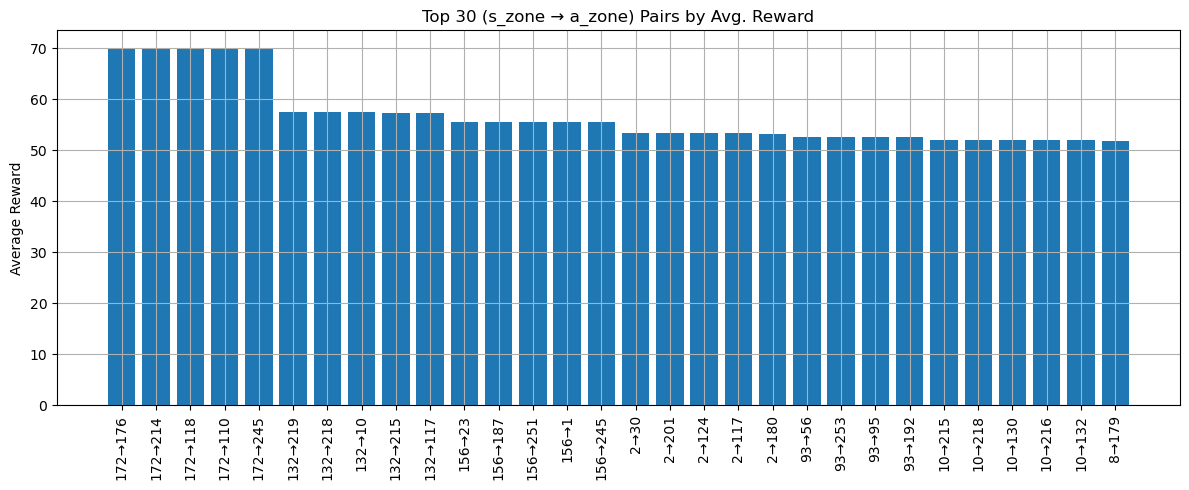

In [22]:
plot_avg_reward_distribution("./data_for_q_learning/q_learning_samples_96.csv", top_n=30)